# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

In [ ]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold


from sklearn import metrics 
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
!pip install catboost
from catboost import CatBoostClassifier



import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import re
lemmatizer = WordNetLemmatizer()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import pickle



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#mouting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Coronavirus Tweets.csv'
#path = '/content/drive/MyDrive/AlmaBetter/Capstone Projects/Coronavirus Tweets Sentiment Analysis/Copy of Coronavirus Tweets.csv'
df = pd.read_csv(path,encoding='latin-1')

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
df.describe(include='int')

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [ ]:
df.describe(include='object')

,Location,TweetAt,OriginalTweet,Sentiment
count,32567,41157,41157,41157
unique,12220,30,41157,5
top,London,20-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Positive
freq,540,3448,1,11422


In [ ]:
df.shape

(41157, 6)

In [ ]:
#Percentage of Null values present in the dataset columns
print(df.isnull().sum()/len(df)*100)

UserName          0.000000
ScreenName        0.000000
Location         20.871298
TweetAt           0.000000
OriginalTweet     0.000000
Sentiment         0.000000
dtype: float64


In [ ]:
#Different types of sentiments 
print(df['Sentiment'].unique())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


In [ ]:
#Dropping the unnecessary columns
df.drop(['UserName','ScreenName'],axis=1,inplace=True)

In [ ]:
#Dropping the null values from the dataset
df.dropna(inplace=True)

In [ ]:
#new shape
df.shape

(32567, 4)

* Original Dataset comprises of 6 columns and 41157 rows.
* There are no duplicates present in the Original Tweet Column.
* Location Column has approx 20% of Null values so we can drop them.
* There are  5 sentiments present in the data.
* The Columns UserName and ScreenName can be dropped as being not so useful.

#### **EDA**

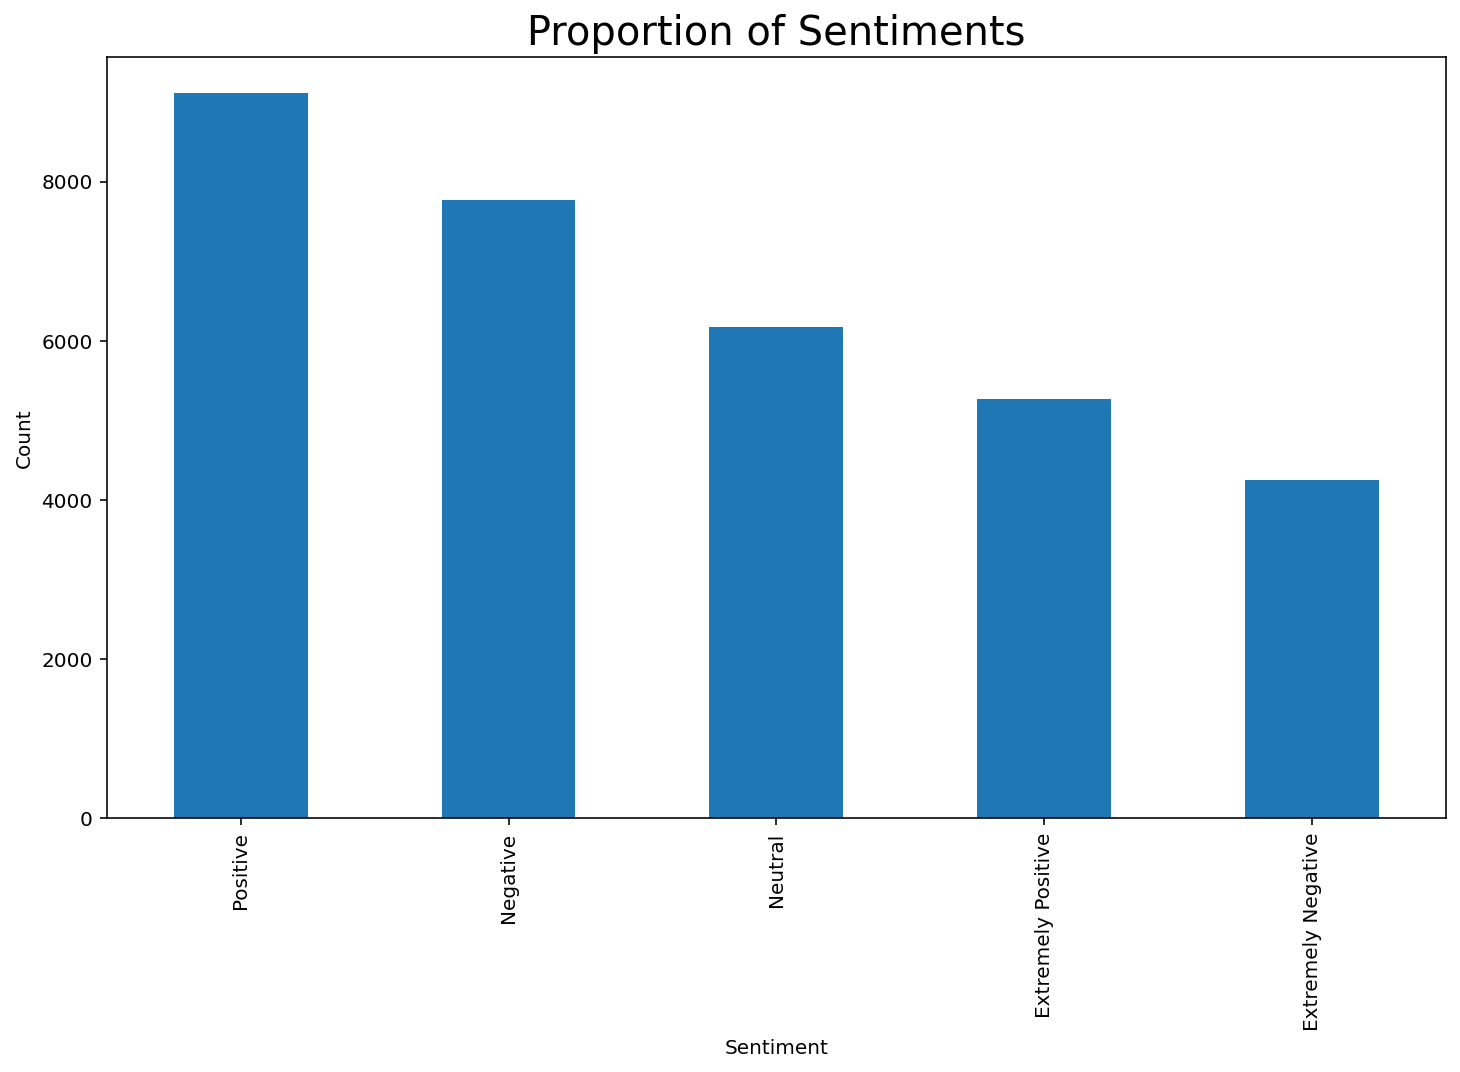

In [ ]:
# Count plot of the target variable
plt.figure(figsize=(12,7))
df.Sentiment.value_counts().plot(kind='bar')
plt.title('Proportion of Sentiments',size=20)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

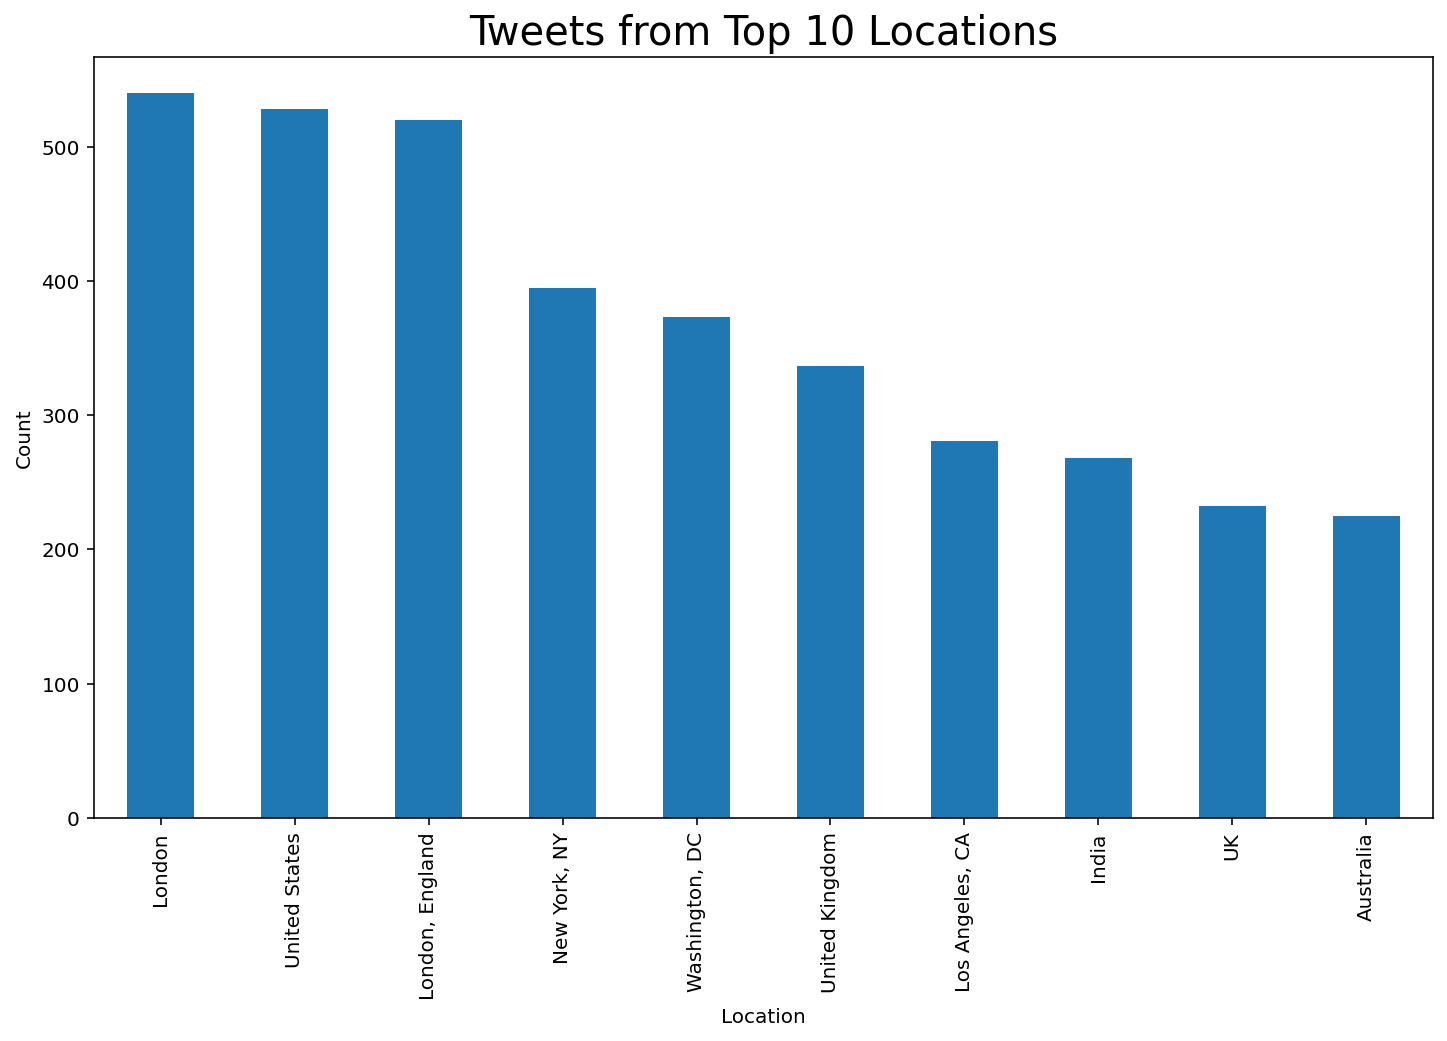

In [ ]:
# Tweets from top 10 locations
plt.figure(figsize=(12,7))
df.Location.value_counts()[:10].plot(kind='bar')
plt.title('Tweets from Top 10 Locations',size=20)
plt.ylabel('Count')
plt.xlabel('Location')
plt.show()

In [ ]:
# Loooking for hash trends
def hashed_words(text):
  hashed_word=[]
  for x in text:
    hashed_word.append(re.findall(r'#(\w+)',x))
  return hashed_word

In [ ]:
# Dictionary to store all the hashtag trends wrt to the sentiments
sentiments = df['Sentiment'].unique()
hashed_dict = {}
for i in sentiments:
  hashed_dict[f'hashed_tags_{i}']=sum(hashed_words(df.loc[df['Sentiment']==i,'OriginalTweet']),[])


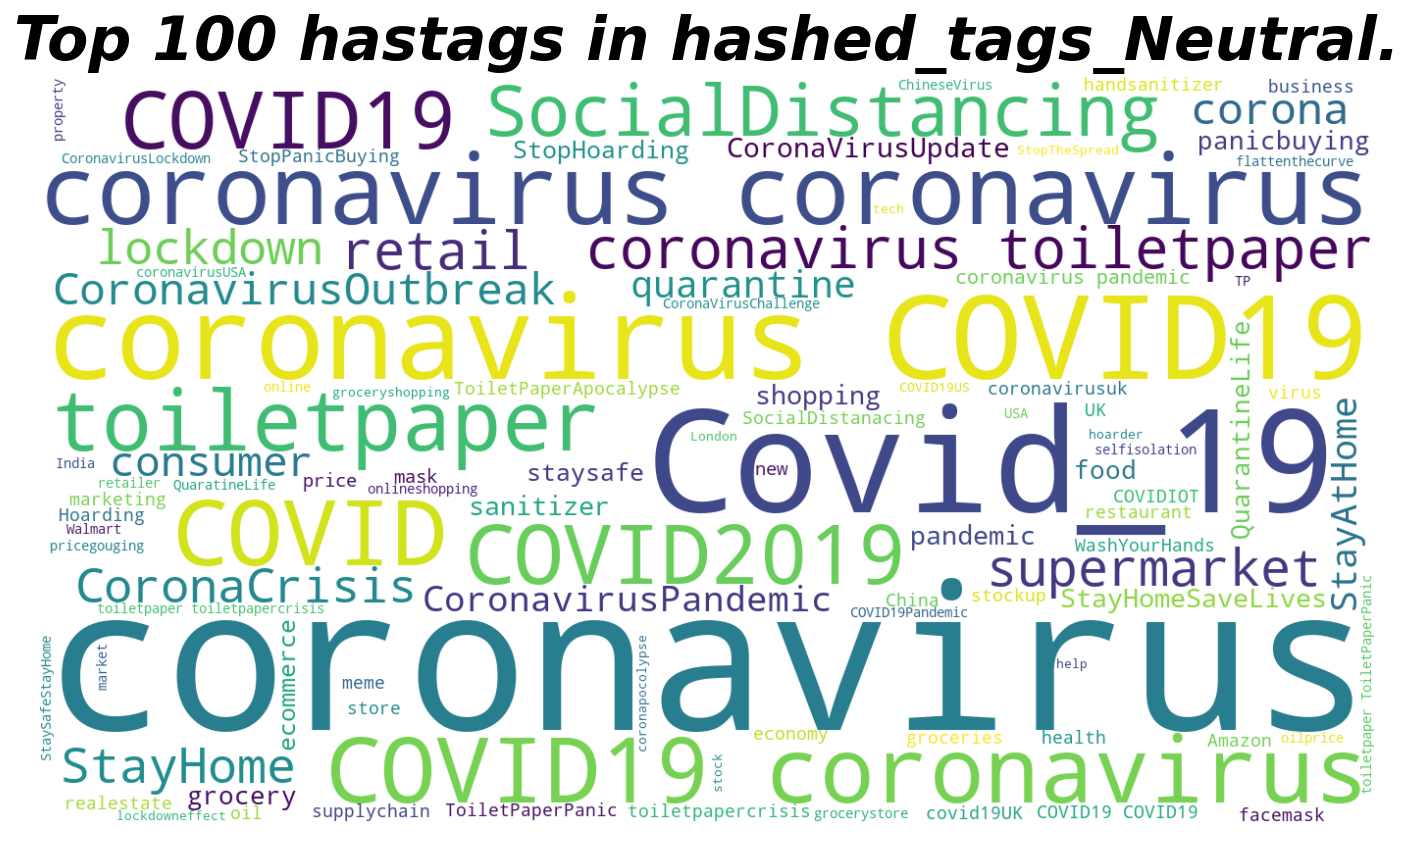

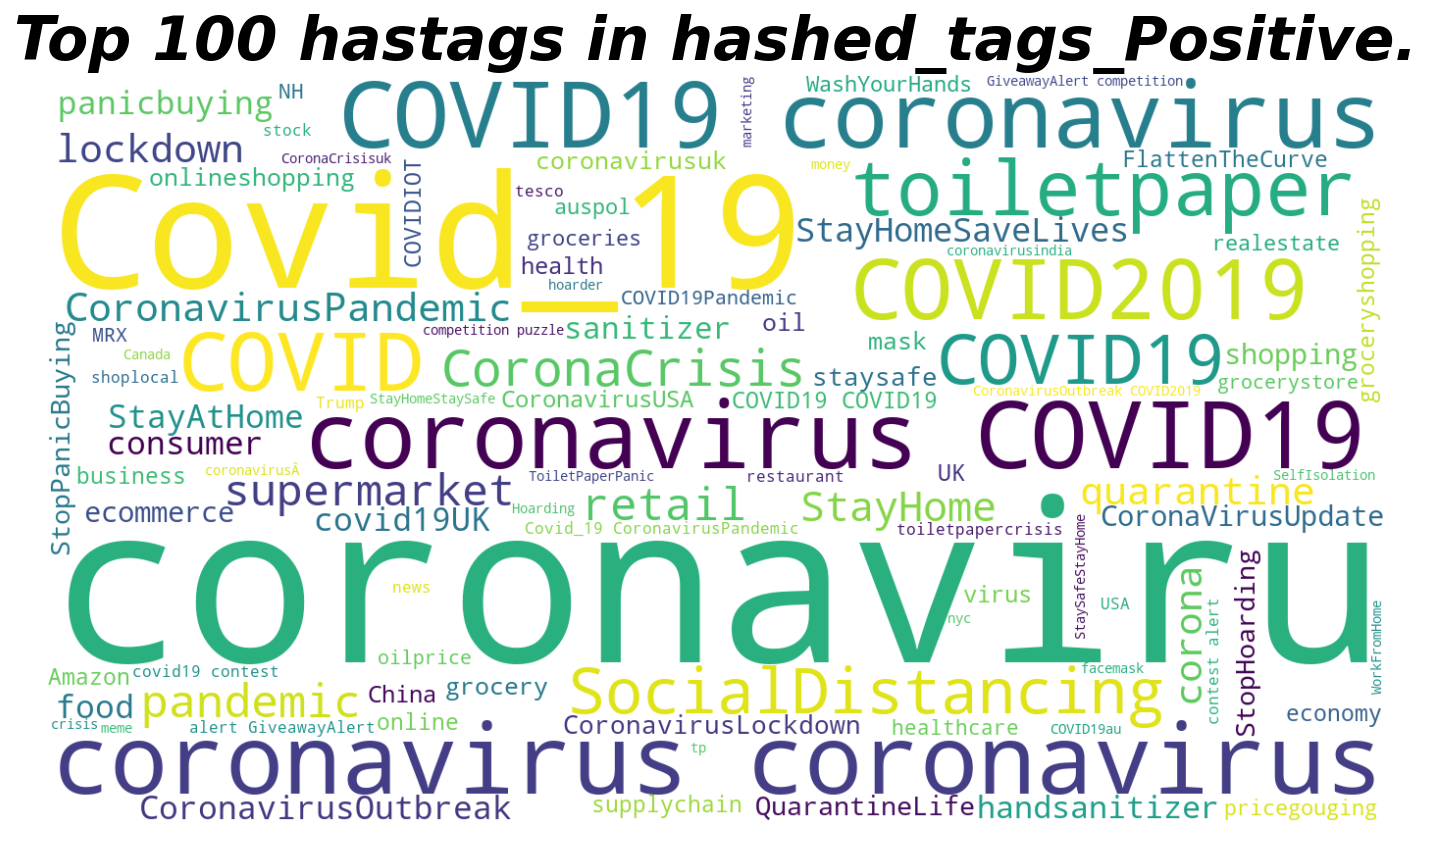

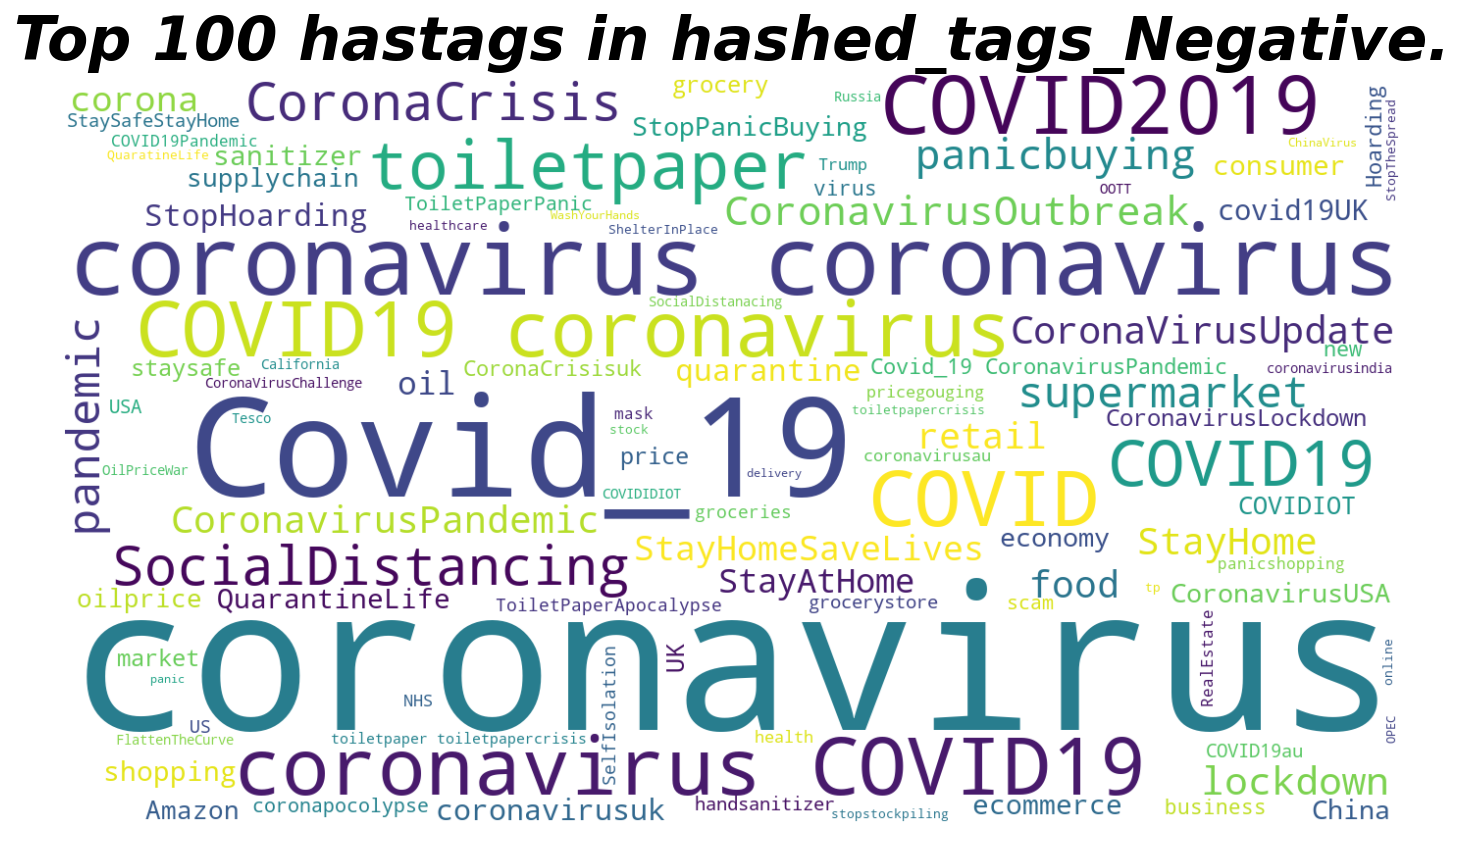

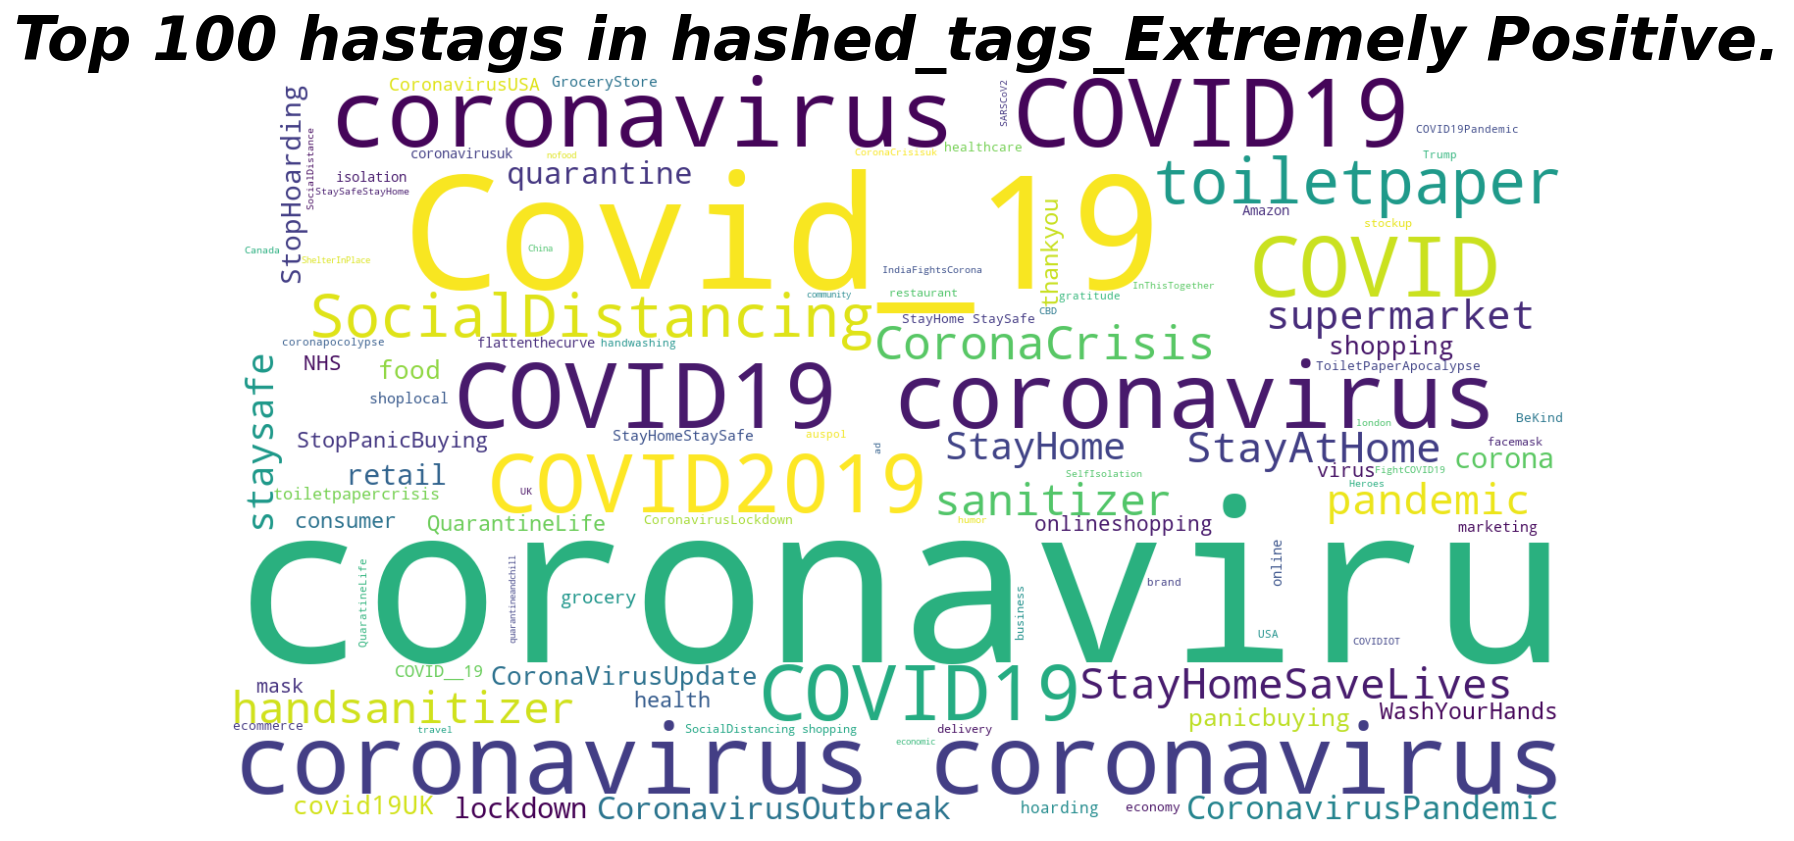

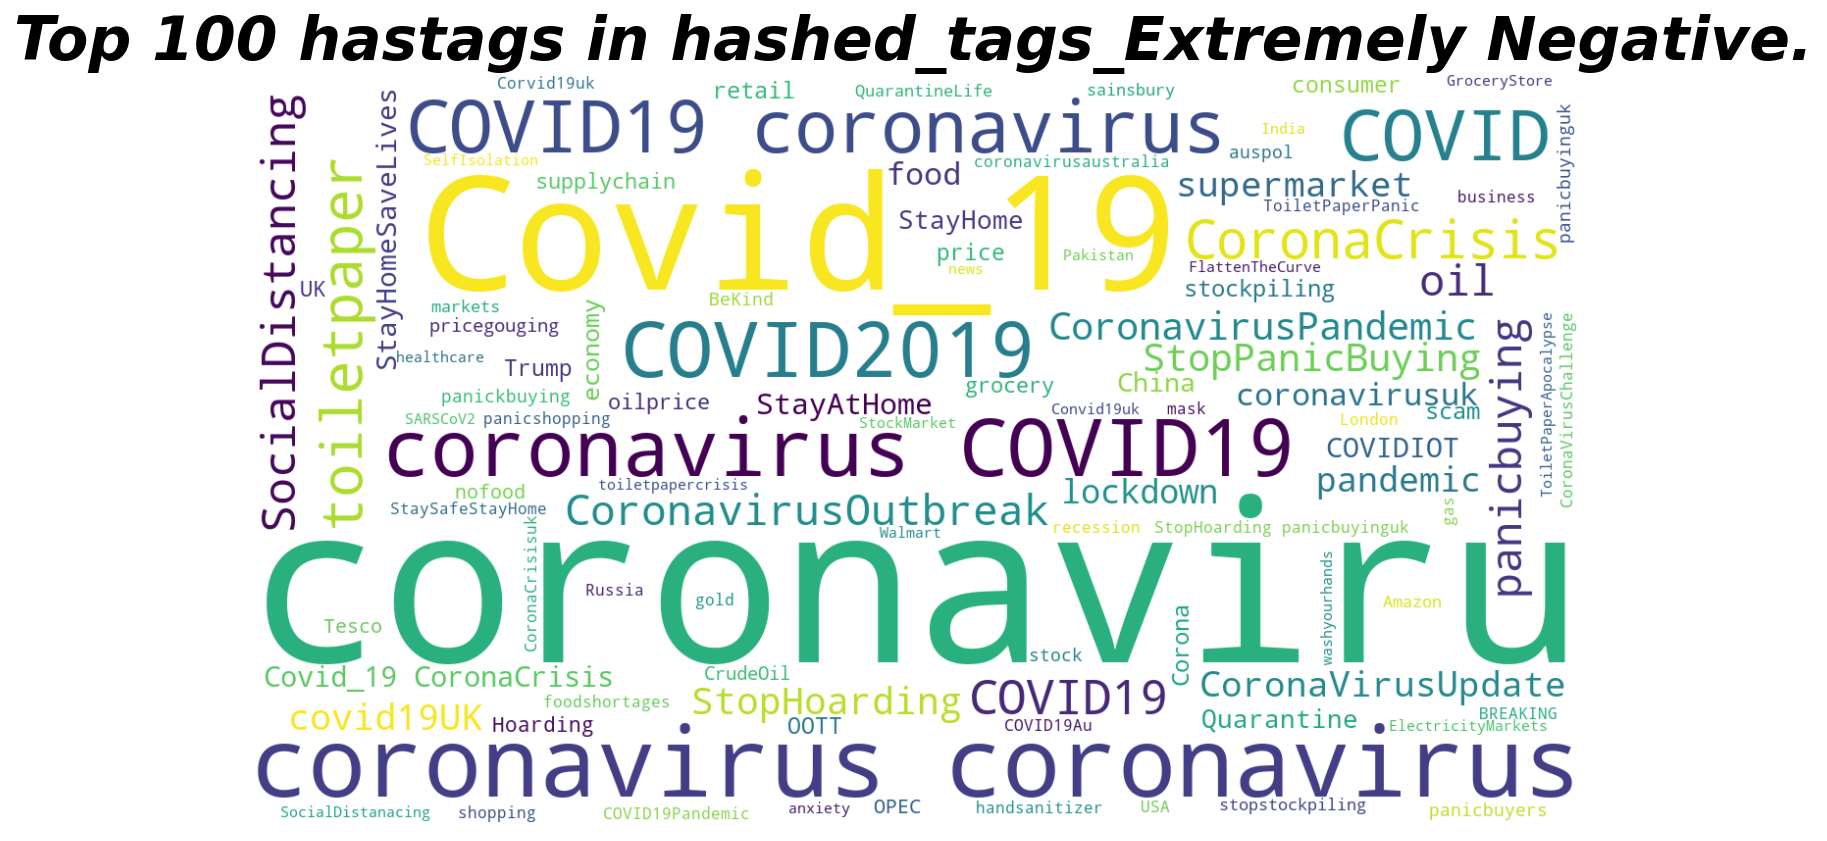

In [ ]:
# Cloud Words plot for displaying top trending hashtags for different Sentiments 
for key in hashed_dict.keys():
  normal_words = ' '.join([text for text in[text for text in hashed_dict[key]]])

  wordcloud = WordCloud(width=1366, height=768, random_state=21,max_words=100 ,max_font_size=700,background_color='white').generate(normal_words)
  plt.figure(figsize=(12, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(f'Top 100 hastags in {key}.',fontweight='bold',fontstyle='italic',fontsize=30)
  plt.axis('off')
  plt.show()
  print('\n')

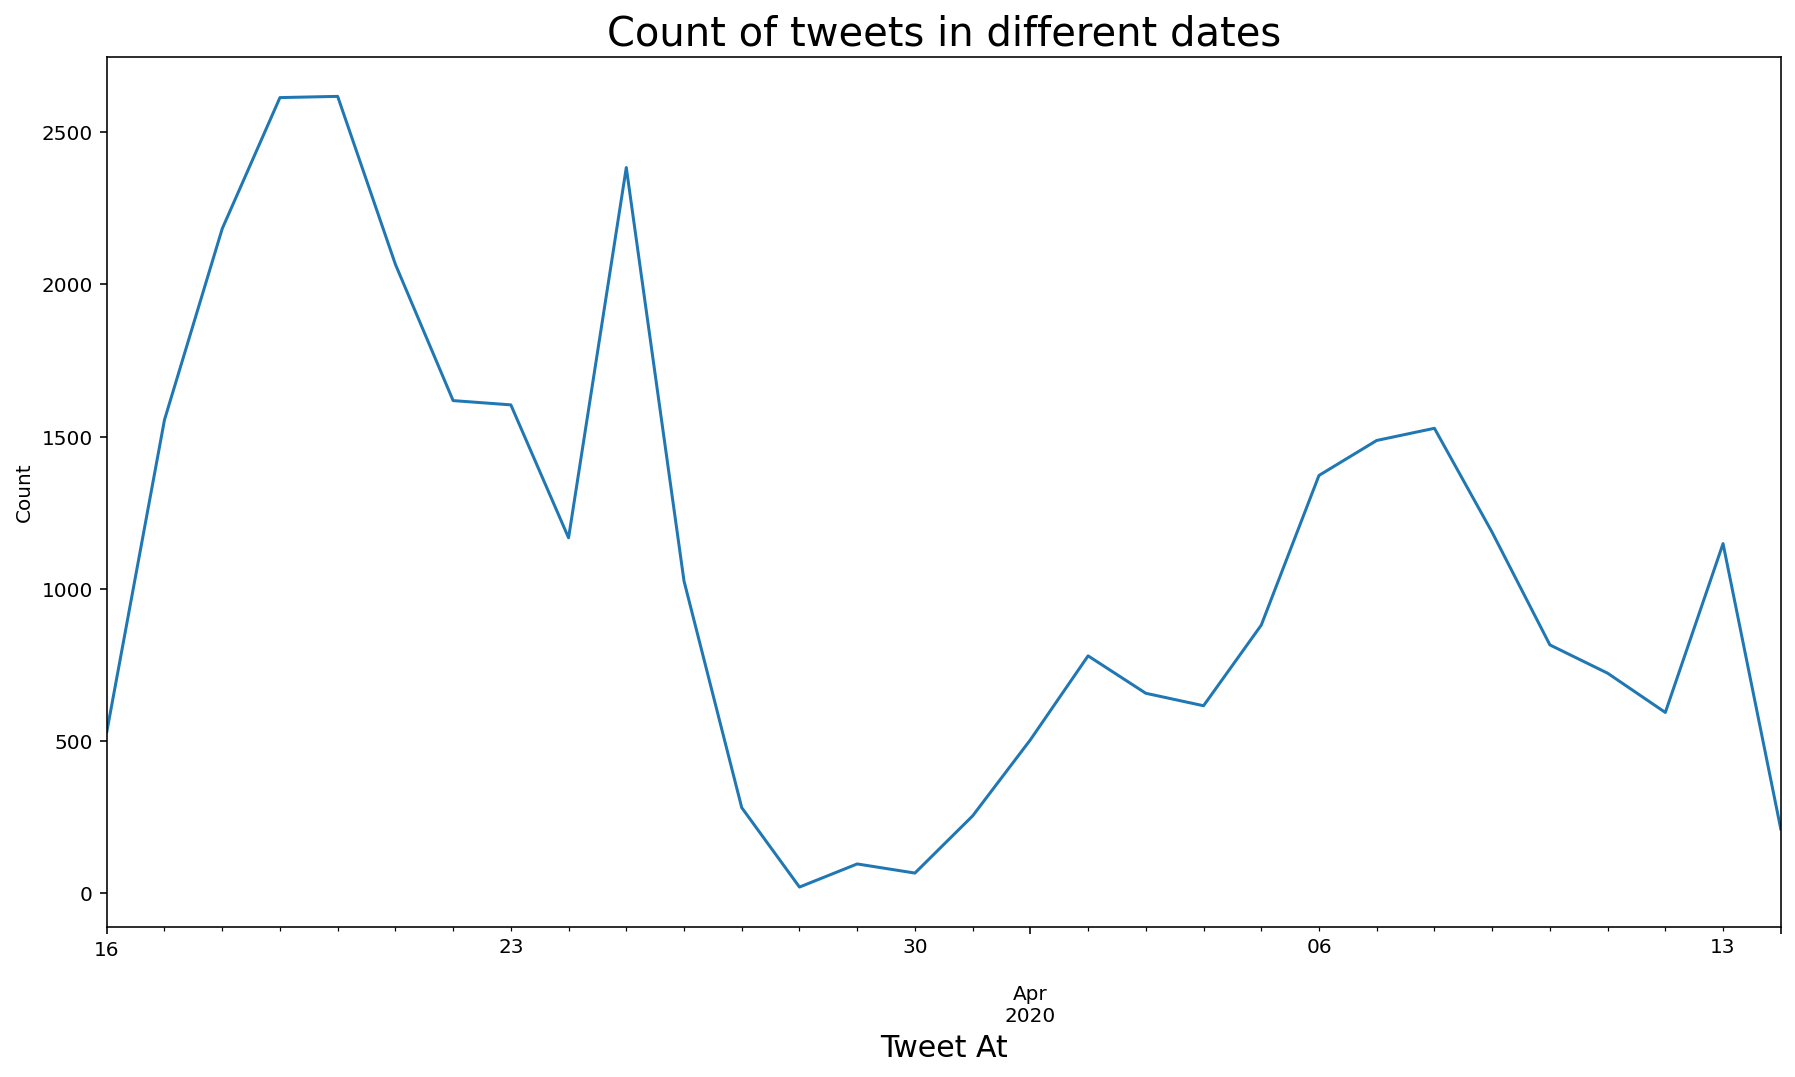

In [ ]:
#Timeline of tweets
df['TweetAt'] = pd.to_datetime(df["TweetAt"],format='%d-%m-%Y') #Converting series to date_time format
plt.figure(figsize=(15,8))
df.groupby('TweetAt').count()['OriginalTweet'].plot()
plt.title("Count of tweets in different dates",size=20)
plt.ylabel('Count')
plt.xlabel('Tweet At',size=15)
plt.show()

In [ ]:
# Dictionary to store all the hashtag trends wrt to the Tweet date
tweet_date = df['TweetAt'].unique()
hashed_dict_tweet_date = {}
for i in tweet_date:
  hashed_dict_tweet_date[f'hashed_tags_{i}']=sum(hashed_words(df.loc[df['TweetAt']==i,'OriginalTweet']),[])

In [ ]:
for date in hashed_dict_tweet_date.keys():
  freq_dist_tags = nltk.FreqDist(hashed_dict_tweet_date[date])
  freq_dist_df = pd.DataFrame({'hashed_words': list(freq_dist_tags.keys()),
                    'Frequency' : list(freq_dist_tags.values())})

  plt.figure(figsize = (12,7))
  sns.barplot(data =freq_dist_df.nlargest(columns = 'Frequency', n = 10), x = 'hashed_words', y = 'Frequency')
  plt.title(f'top 10 hashtag trends in {date} date',fontweight='bold',fontstyle='italic',fontsize=20)
  plt.xticks(rotation=45)
  plt.show()
  print('\n')

* Maximum number of tweets are of Positive sentiment & Extreamly Negative Sentiment are least in number. 
* All the tweets have been done in the month of <b> March and April.</b>
* Most of the tweets are from <b> London & US </b>.
* The difference among the word clouds of different Sentiments are not clear. So we need to clean the text.

#### **Cleaning**

In [ ]:
def cleaning(text):
  stemmer=PorterStemmer()
  cleaned_text = re.sub(r'@[\w]*','', text)     # removal of @users as they are don't impart much info 
  cleaned_text = re.sub('https?://\S+|www\.\S+', '', cleaned_text)    # removal of links
  cleaned_text = re.sub("[^a-zA-Z]"," ",cleaned_text)                 # removal of all the punctuations,special character, numbers
  
  cleaned_text = cleaned_text.lower()                                 # converting to lower case 
  
  cleaned_text = cleaned_text.split()                                 # tokenization
  
  cleaned_text = [stemmer.stem(word) for word in cleaned_text if not word  in stopwords.words("english")]  # word Stemming after removal of stopwords
  
  cleaned_text  = ' '.join(cleaned_text)                              # joining of tokenized words
  
  return cleaned_text

In [ ]:
# Checking if the above function is effective
display(df.loc[0,'OriginalTweet'],cleaning(df.loc[0,'OriginalTweet']))

In [ ]:
df['cleaned_tweet'] = df['OriginalTweet'].apply(cleaning)

In [ ]:
df.head()

In [ ]:
# Displaying wordclouds for cleaned tweets in different sentimental situations

for i in df['Sentiment'].unique():
  normal_words = ' '.join([text for text in[text for text in df.loc[df['Sentiment']==i,'cleaned_tweet']]])

  wordcloud = WordCloud(width=1366, height=768, random_state=21,max_words=100 ,max_font_size=700,background_color='black').generate(normal_words)
  plt.figure(figsize=(12, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(f'Top words repeated with {i} sentiment',fontsize=20)
  plt.axis('off')
  plt.show()
  print('\n')

In [ ]:
# Saving Cleaned Tweets as new dataframe
df[['cleaned_tweet','Sentiment']].to_csv('/content/drive/MyDrive/Cleaned_tweets.csv',header=True,index=False)

#### **Vectorization of the words**

In [ ]:
new_df  = pd.read_csv('/content/drive/MyDrive/Cleaned_tweets.csv')


In [ ]:
new_df = new_df.fillna('')

In [ ]:
new_df.head()

In [ ]:
## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(new_df['cleaned_tweet']).toarray()
y = new_df['Sentiment'].values

In [ ]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### **Modelling**

In [ ]:
def models():
  '''
  This Function returns a dictionary of Classification Algorithms 
  '''
  models = dict()
  
  models['Naive Bayes'] = MultinomialNB()
  models['Logistic Regression'] = LogisticRegression()
  models['knn'] = KNeighborsClassifier()
  models['Decision Tree'] = DecisionTreeClassifier()
  models['XGBoost'] = XGBClassifier()
  models['Extra Trees Classifier'] = ExtraTreesClassifier()
  models['Random Forest'] = RandomForestClassifier()
  models['CatBoost Classifier'] = CatBoostClassifier()

  return models

In [ ]:
def model_predictions(models,X_train,X_test,y_train):
    '''
    This function is used for training and testing our list of models, 
    which is used for returning training and testing predictions those in turn used for evaluation.  
    '''
    names=[]
    training_preds = []
    test_preds = []
    
    for name, model in models.items():                               # Looping over our list of models
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train).tolist()
        training_preds.append(train_pred)
        names.append(name)

        file=open(f"{name}.pkl", "wb")                               # Pickling our models for future uttlity
        pickle.dump(model, file)
        
        test_pred = model.predict(X_test).tolist()
        test_preds.append(test_pred)

        
     
    training_pred_dict = dict(zip(names, training_preds))           # Zipping our models and their 
                                                                     # corresponding training predictions into a dictionary.
    
    train_pred_df = pd.DataFrame.from_dict(training_pred_dict)       # We're converting the above dictionary to a DataFrame.
    
    
    test_pred_dict = dict(zip(names, test_preds))                    # Zipping our models and their 
                                                                     # corresponding test predictions into a dictionary.
    
    test_pred_df = pd.DataFrame.from_dict(test_pred_dict)           # We're converting the above dictionary to a DataFrame.
    
    return train_pred_df,test_pred_df

In [ ]:
def evaluation_function(y_train, y_test, train_pred_df, test_pred_df, metric_name):
    '''
    This function is used to compute the Evaluation Metrics for traing and test predictions of our list of models 
    '''
    models = train_pred_df.columns.tolist()

    metrics_train = []
    metrics_test = []
    for model in models:
        if metric_name == 'Recall': 
            metric_train = metrics.recall_score(y_train, train_pred_df[model],average='weighted')  
            metric_test = metrics.recall_score(y_test, test_pred_df[model],average='weighted')  

        elif metric_name == 'Precision': 
            metric_train = metrics.precision_score(y_train, train_pred_df[model],average='weighted')
            metric_test = metrics.precision_score(y_test, test_pred_df[model],average='weighted')

        elif metric_name == 'F1_score': 
            metric_train = metrics.f1_score(y_train, train_pred_df[model],average='weighted')
            metric_test = metrics.f1_score(y_test, test_pred_df[model],average='weighted')  

        elif metric_name == 'Accuracy': 
            metric_train = metrics.accuracy_score(y_train, train_pred_df[model])
            metric_test = metrics.accuracy_score(y_test, test_pred_df[model])

        metrics_train.append(metric_train)
        metrics_test.append(metric_test)

    metrics_train_dict = dict(zip(models, metrics_train))  # Zipping our models and their corresponding 
                                                           # Evaluation results of training predictions into a dictionary.

    metrics_test_dict = dict(zip(models,metrics_test))  # Zipping our models and their corresponding 
                                                        # Evaluation results of test predictions into a dictionary.
    
    metrics_dict={'train':metrics_train_dict,
                 'test':metrics_test_dict}
    metrics_df = pd.DataFrame(metrics_dict)    # Converting our metric dictionaries into a DataFrame.
    metrics_df = metrics_df.transpose()        # Transposing the above DataFrame for our convenience
    metrics_df['Evaluation'] = metric_name     
    first_col = metrics_df.pop('Evaluation')
    metrics_df.insert(0, 'Evaluation', first_col)
    return metrics_df

In [ ]:
#Prediction
train_pred_df,test_pred_df = model_predictions(models(),X_train,X_test,y_train)

In [ ]:
def value_correction_format(dataframe,column):
  """
  This fuction is used to correct the formatting of the output values 
  """
  lst = []
  for  i in dataframe[column]:
    lst.extend(i)
  dataframe[column] = lst
  return dataframe

In [ ]:
train_pred_df = value_correction_format(train_pred_df,'CatBoost Classifier')
test_pred_df = value_correction_format(test_pred_df,'CatBoost Classifier')

# display(train_pred_df,test_pred_df)

In [ ]:
metrics_df = evaluation_function(y_train, y_test, train_pred_df, test_pred_df,'Accuracy')
metrics_df

In [ ]:
accuracy = evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'Accuracy')
accuracy.transpose().iloc[1:,:].plot(kind='bar',figsize=(15,6))
plt.ylabel('Accuracy')
plt.title('Accuracy for different Models')
plt.xticks(rotation=45)
plt.yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.show()

In [ ]:
metrics_df = evaluation_function(y_train, y_test, train_pred_df, test_pred_df,'Recall')
metrics_df

In [ ]:
recall = evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'Recall')
recall.transpose().iloc[1:,:].plot(kind='bar',figsize=(15,6))
plt.ylabel('Recall')
plt.title('Recall for different Models')
plt.xticks(rotation=45)
plt.yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.show()

In [ ]:
metrics_df = evaluation_function(y_train, y_test, train_pred_df, test_pred_df,'Precision')
metrics_df

In [ ]:
precision = evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'Precision')
precision.transpose().iloc[1:,:].plot(kind='bar',figsize=(15,6))
plt.ylabel('Precision')
plt.title('Precision for different Models')
plt.xticks(rotation=45)
plt.yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.show()

In [ ]:
metrics_df = evaluation_function(y_train, y_test, train_pred_df, test_pred_df,'F1_score')
metrics_df

In [ ]:
f1_score = evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'F1_score')
f1_score.transpose().iloc[1:,:].plot(kind='bar',figsize=(15,6))
plt.ylabel('F1 score')
plt.title('F1 score for different Models')
plt.xticks(rotation=45)
plt.yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.show()

Visualizing all the graphs of different metrics....
* <b> Naive Bayes, Logistic Regression and Cat Boost </b> are performing better than other algorithms.
* The tree based algorithms like <b> Decision tree, Extra Tree Classifier and Random Forest </b> are more likely to overfit.
*Among all the algorithms <b> Cat Boost </b> is performing best.